## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [3]:
df

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,40.67853,-73.94995,Private room,70,2,0,0.00,2,9
48891,Brooklyn,40.70184,-73.93317,Private room,40,4,0,0.00,2,36
48892,Manhattan,40.81475,-73.94867,Entire home/apt,115,10,0,0.00,1,27
48893,Manhattan,40.75751,-73.99112,Shared room,55,1,0,0.00,6,2


* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [4]:
# are there any NA's?
# They already used fillna(0) when loading the CSV, but let's make sure.
df.isna().any()

neighbourhood_group               False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [5]:
# OK, let's do the rest
from sklearn.model_selection import train_test_split

In [6]:
# log transform on price
df.price = np.log1p(df.price)

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

In [8]:
del df_train['price']
del df_val['price']
del df_test['price']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [9]:
from sklearn.feature_extraction import DictVectorizer

In [10]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



/Users/ziri/anaconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

## _Question 1 Answer_

`room_type` is used for splitting the data

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [16]:
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(round(rmse, 3))

0.462


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

## _Question 2 answer_

Perhaps `0.459`? I'm off by `0.003`.

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [17]:
from tqdm.auto import tqdm

In [18]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    scores.append((n, rmse))

100%|██████████| 20/20 [00:32<00:00,  1.60s/it]


In [19]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

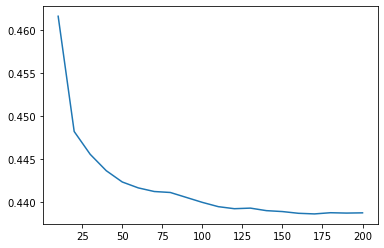

In [20]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [21]:
df_scores

,n_estimators,rmse
0,10,0.461563
1,20,0.448184
2,30,0.445535
3,40,0.443637
4,50,0.442325
5,60,0.441639
6,70,0.441218
7,80,0.441106
8,90,0.440533
9,100,0.439958


In [23]:
df_scores[df_scores.rmse == df_scores.rmse.min()]

,n_estimators,rmse
16,170,0.438617


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

## _Question 3 answer_

My lowest value is `170`... 

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [24]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    for n in tqdm(range(10, 201, 10)):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        scores.append((n, d, rmse))

100%|██████████| 4/4 [01:48<00:00, 27.12s/it]


In [25]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse'])

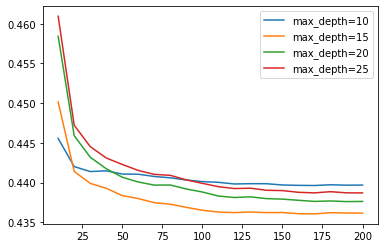

In [26]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]

    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

## _Question 4 answer_

The best maximum depth is `15`.

***Bonus***: unlikely to change. Changing the random state might change results on the first iterations, but will eventually converge to similar results as other random states.

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [27]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [28]:
gains = zip(dv.get_feature_names(), rf.feature_importances_)
df_gains = pd.DataFrame(gains, columns=['feature_name', 'gain'])

/Users/ziri/anaconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
df_gains

,feature_name,gain
0,availability_365,0.076264
1,calculated_host_listings_count,0.030102
2,latitude,0.152775
3,longitude,0.154101
4,minimum_nights,0.053252
5,neighbourhood_group=Bronx,0.000265
6,neighbourhood_group=Brooklyn,0.000966
7,neighbourhood_group=Manhattan,0.034047
8,neighbourhood_group=Queens,0.001166
9,neighbourhood_group=Staten Island,0.000084


In [32]:
df_gains.sort_values(by='gain', ascending=False)

,feature_name,gain
12,room_type=Entire home/apt,0.391898
3,longitude,0.154101
2,latitude,0.152775
0,availability_365,0.076264
11,reviews_per_month,0.054430
4,minimum_nights,0.053252
10,number_of_reviews,0.041594
7,neighbourhood_group=Manhattan,0.034047
1,calculated_host_listings_count,0.030102
14,room_type=Shared room,0.005023


In [33]:
df_gains[df_gains['gain'] == df_gains['gain'].max()]

,feature_name,gain
12,room_type=Entire home/apt,0.391898


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

## _Question 5 answer_

The most important feature is `room_type=Entire home/apt`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [34]:
# install xgboost
import xgboost as xgb

In [35]:
# create DMatrix for train and validation
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/Users/ziri/anaconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [37]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [38]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

[0]	train-rmse:3.02752	val-rmse:3.02415
[5]	train-rmse:0.67490	val-rmse:0.67752
[10]	train-rmse:0.43912	val-rmse:0.44981
[15]	train-rmse:0.42259	val-rmse:0.43827
[20]	train-rmse:0.41716	val-rmse:0.43691
[25]	train-rmse:0.41365	val-rmse:0.43621
[30]	train-rmse:0.40712	val-rmse:0.43543
[35]	train-rmse:0.40444	val-rmse:0.43510
[40]	train-rmse:0.40103	val-rmse:0.43466
[45]	train-rmse:0.39723	val-rmse:0.43371
[50]	train-rmse:0.39446	val-rmse:0.43384
[55]	train-rmse:0.39129	val-rmse:0.43378
[60]	train-rmse:0.38743	val-rmse:0.43404
[65]	train-rmse:0.38421	val-rmse:0.43450
[70]	train-rmse:0.38117	val-rmse:0.43467
[75]	train-rmse:0.37801	val-rmse:0.43489
[80]	train-rmse:0.37668	val-rmse:0.43526
[85]	train-rmse:0.37259	val-rmse:0.43537
[90]	train-rmse:0.36998	val-rmse:0.43539
[95]	train-rmse:0.36742	val-rmse:0.43579
[99]	train-rmse:0.36478	val-rmse:0.43621


Now change `eta` first to `0.1` and then to `0.01`

In [39]:
xgb_params['eta'] = 0.1
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)


[0]	train-rmse:3.87217	val-rmse:3.86889
[5]	train-rmse:2.31905	val-rmse:2.31692
[10]	train-rmse:1.41910	val-rmse:1.41786
[15]	train-rmse:0.91299	val-rmse:0.91348
[20]	train-rmse:0.64528	val-rmse:0.64883
[25]	train-rmse:0.51733	val-rmse:0.52364
[30]	train-rmse:0.46186	val-rmse:0.47101
[35]	train-rmse:0.43843	val-rmse:0.44997
[40]	train-rmse:0.42770	val-rmse:0.44150
[45]	train-rmse:0.42222	val-rmse:0.43795
[50]	train-rmse:0.41868	val-rmse:0.43589
[55]	train-rmse:0.41644	val-rmse:0.43515
[60]	train-rmse:0.41432	val-rmse:0.43460
[65]	train-rmse:0.41226	val-rmse:0.43400
[70]	train-rmse:0.41059	val-rmse:0.43361
[75]	train-rmse:0.40876	val-rmse:0.43336
[80]	train-rmse:0.40747	val-rmse:0.43306
[85]	train-rmse:0.40626	val-rmse:0.43299
[90]	train-rmse:0.40478	val-rmse:0.43280
[95]	train-rmse:0.40406	val-rmse:0.43272
[99]	train-rmse:0.40277	val-rmse:0.43250


In [40]:
xgb_params['eta'] = 0.01
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

[0]	train-rmse:4.25336	val-rmse:4.25010
[5]	train-rmse:4.04779	val-rmse:4.04454
[10]	train-rmse:3.85242	val-rmse:3.84921
[15]	train-rmse:3.66674	val-rmse:3.66359
[20]	train-rmse:3.49030	val-rmse:3.48719
[25]	train-rmse:3.32263	val-rmse:3.31956
[30]	train-rmse:3.16332	val-rmse:3.16029
[35]	train-rmse:3.01196	val-rmse:3.00898
[40]	train-rmse:2.86817	val-rmse:2.86533
[45]	train-rmse:2.73158	val-rmse:2.72884
[50]	train-rmse:2.60185	val-rmse:2.59925
[55]	train-rmse:2.47865	val-rmse:2.47612
[60]	train-rmse:2.36167	val-rmse:2.35927
[65]	train-rmse:2.25061	val-rmse:2.24835
[70]	train-rmse:2.14519	val-rmse:2.14303
[75]	train-rmse:2.04514	val-rmse:2.04311
[80]	train-rmse:1.95022	val-rmse:1.94827
[85]	train-rmse:1.86015	val-rmse:1.85833
[90]	train-rmse:1.77472	val-rmse:1.77302
[95]	train-rmse:1.69373	val-rmse:1.69214
[99]	train-rmse:1.63198	val-rmse:1.63045


Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* 0.01

## _Question 6 answer_

`eta=0.1` has the lowest RMSE with a value of `0.43250`

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

